In [9]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import glob
import matplotlib.pyplot as plt
import warnings

from utils.conn_data import load_pickle

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [10]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "src", 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [11]:
all_parents = []
for fs in fs_methods:
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]
        obj = load_pickle(path=file)
        parents_of_target_df = obj["parents_of_target"]

        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        all_parents.append(parents_of_target_df)
all_parents_df = pd.concat(all_parents)

In [12]:
ticker = "SPY"
etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

etf_df = etf_df.sort_values(by=["date"])

sets_over_time = []
for date in etf_df["date"].unique():
    day = etf_df.loc[etf_df["date"] == date]

    tot = 0
    inter = set()
    for fs in day["fs"].dropna().unique():
        set_fs = set(list(day.loc[(day['fs'] == fs)]["cluster"].dropna()))
        set_intersection = set(list(day["cluster"].dropna()))

        intersection = set_fs.intersection(set_intersection)
        jacard_adj = len(intersection) / len(set_intersection)

        out = pd.DataFrame([{
            
            "date": date,
            "fs": fs,
            "nominator": set_fs,
            "denominator": set_intersection,
            "jacard_adj": jacard_adj
            
            }])

        sets_over_time.append(out)
sets_over_time_df = pd.concat(sets_over_time)
sets_over_time_df["jacard_adj"] = sets_over_time_df["jacard_adj"] * 100

<AxesSubplot:xlabel='date'>

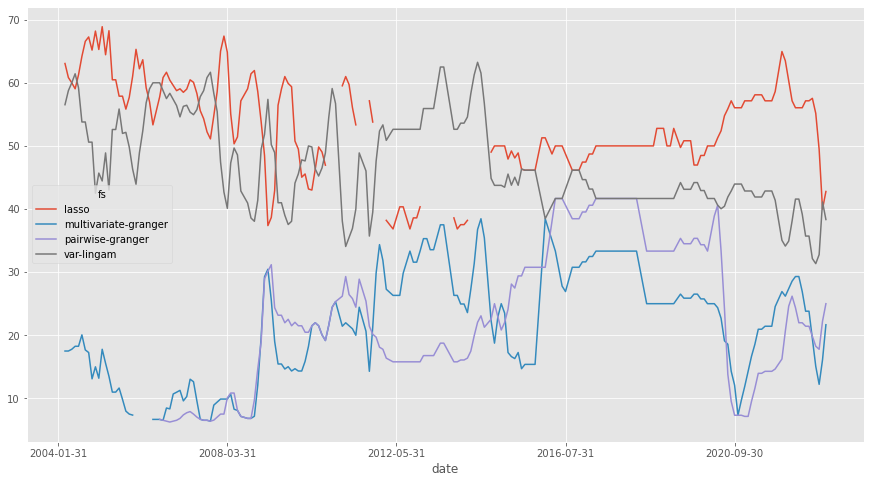

In [5]:
pivot_df = sets_over_time_df.pivot(index=["date"], columns=["fs"], values=["jacard_adj"])
pivot_df.columns = pivot_df.columns.droplevel()

pivot_df.rolling(window=3).mean().plot(figsize=(15, 8))

In [6]:
pivot_df.rolling(window=3).mean().mean().sort_values()

fs
multivariate-granger    21.749422
pairwise-granger        23.006591
var-lingam              47.033720
lasso                   52.927679
dtype: float64